# **ALFA dataset Anomaly Classificataion using Mcfly module reference, torch Windows 40**

**Anomaly Classification using CNN**

In [48]:
!pip install sktime
!pip install mcfly

## **Setup Dependencies**

In [65]:
import os
import sys
import json
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import timedelta
from collections import Counter
from sktime.datatypes import convert_to
from timeit import default_timer as timer
from sktime.datasets import load_from_tsfile
from sklearn.utils import shuffle
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sktime.datasets import load_from_tsfile_to_dataframe
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from mcfly.modelgen import generate_models
from mcfly.find_architecture import find_best_architecture
from mcfly.find_architecture import train_models_on_samples
from tensorflow.keras.metrics import AUC
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
import torch

warnings.filterwarnings('ignore')
np.random.seed(42)

## **Load Dataset**

The given size (N, seq_len, features) applicable for mcfly

In [66]:
# no rolling stats
X = np.load('/kaggle/input/alfa-seq-dataset/ALFA_seq_dataset_complete/alfa_dataset_complete_sequence_X.npy')
y = np.load('/kaggle/input/alfa-seq-dataset/ALFA_seq_dataset_complete/alfa_dataset_complete_sequence_y.npy')
print(X.shape)
print(y.shape)

(3482, 40, 17)
(3482,)


**Swapaxes, output shape (N,features,seq_len), its required for pytorch**

In [67]:
X = np.swapaxes(X, 1, 2)
X.shape

(3482, 17, 40)

#### **Z-score normalize**

In [68]:
mean = np.mean(X, axis=(0,2), keepdims=True)
std = np.std(X, axis=(0, 2), keepdims=True)
X_norm = (X - mean) / std
print(X_norm.shape)

(3482, 17, 40)


**Label encoding**

Applicable for mcfly only

In [61]:
ohe = OneHotEncoder()

y = ohe.fit_transform(y.reshape(-1, 1)).toarray()
y.shape

(3482, 5)

## **Train valid test split**

In [69]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.10, random_state=40,
                                                    shuffle=True, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train,
                                                  test_size=0.10, random_state=40,
                                                  shuffle=True, stratify=y_train)

print(X_train.shape, X_val.shape, X_test.shape)
print(y_train.shape, y_val.shape, y_test.shape)

(2819, 17, 40) (314, 17, 40) (349, 17, 40)
(2819,) (314,) (349,)


#### **Class weights**

In [12]:
class_weights = compute_class_weight(
    class_weight = "balanced",
    classes = np.unique(np.argmax(y, axis=1)),
    y = np.argmax(y, axis=1)
)

class_weights = dict(zip(np.unique(np.argmax(y, axis=1)), class_weights))
class_weights

AxisError: axis 1 is out of bounds for array of dimension 1

## **Automatically find the models and model selection**

Selecting reference model using mcfly, finding between deeplstm, CNN, ResNet, InceptionTime

In [64]:
%%time

file_name = f"model-comparison-20220808.json"
output_file = os.path.join("/kaggle/working/", file_name)
model_path = os.path.join("/kaggle/working/")

metric_key = "pr_auc"
metric = AUC(curve="PR", name=metric_key )

# metric_key = "accuracy"
# metric = "accuracy"

models = generate_models(
    X_train.shape,
    y_train.shape[1],
    number_of_models=6,
    model_types=['DeepConvLSTM','CNN', 'ResNet','InceptionTime'],
    metrics=[metric]
)

history, val_metrics, val_losses = train_models_on_samples(
    X_train=X_train,
    y_train=y_train,
    X_val=X_val,
    y_val=y_val,
    models=models,
    nr_epochs=30,
    verbose=True,
    model_path=model_path,
    outputfile=output_file,
    subset_size=int(X_train.shape[0] / 2),
    class_weight=class_weights
)

Set maximum kernel size for InceptionTime models to number of timesteps.
Generated models will be trained on subset of the data (subset size: 1409).
Training model 0 ResNet
Epoch 1/30
71/71 [==============================] - 19s 64ms/step - loss: 2.4790 - pr_auc: 0.2142 - val_loss: 74.4353 - val_pr_auc: 0.1602
Epoch 2/30
71/71 [==============================] - 2s 24ms/step - loss: 2.0731 - pr_auc: 0.1820 - val_loss: 121.5236 - val_pr_auc: 0.1781
Epoch 3/30
71/71 [==============================] - 2s 24ms/step - loss: 1.8798 - pr_auc: 0.1842 - val_loss: 17.8350 - val_pr_auc: 0.2170
Epoch 4/30
71/71 [==============================] - 2s 24ms/step - loss: 1.9509 - pr_auc: 0.1971 - val_loss: 3.1214 - val_pr_auc: 0.2043
Epoch 5/30
71/71 [==============================] - 2s 25ms/step - loss: 1.7193 - pr_auc: 0.2019 - val_loss: 1.5044 - val_pr_auc: 0.3837
Epoch 6/30
71/71 [==============================] - 2s 24ms/step - loss: 1.6840 - pr_auc: 0.1957 - val_loss: 2.6191 - val_pr_auc: 0.2230


In [66]:
best_model_index = np.argmax(val_metrics[metric_key])
best_model, best_params, best_model_type = models[best_model_index]

print(best_model_index)
print("Best model type:", best_model_type)

3
Best model type: InceptionTime


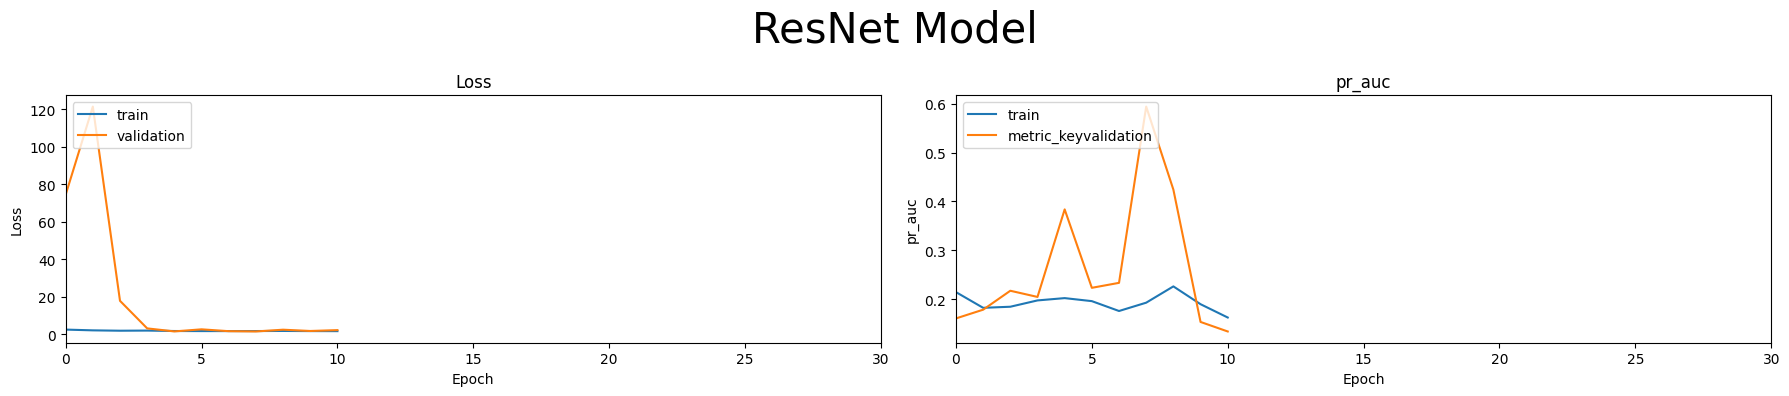

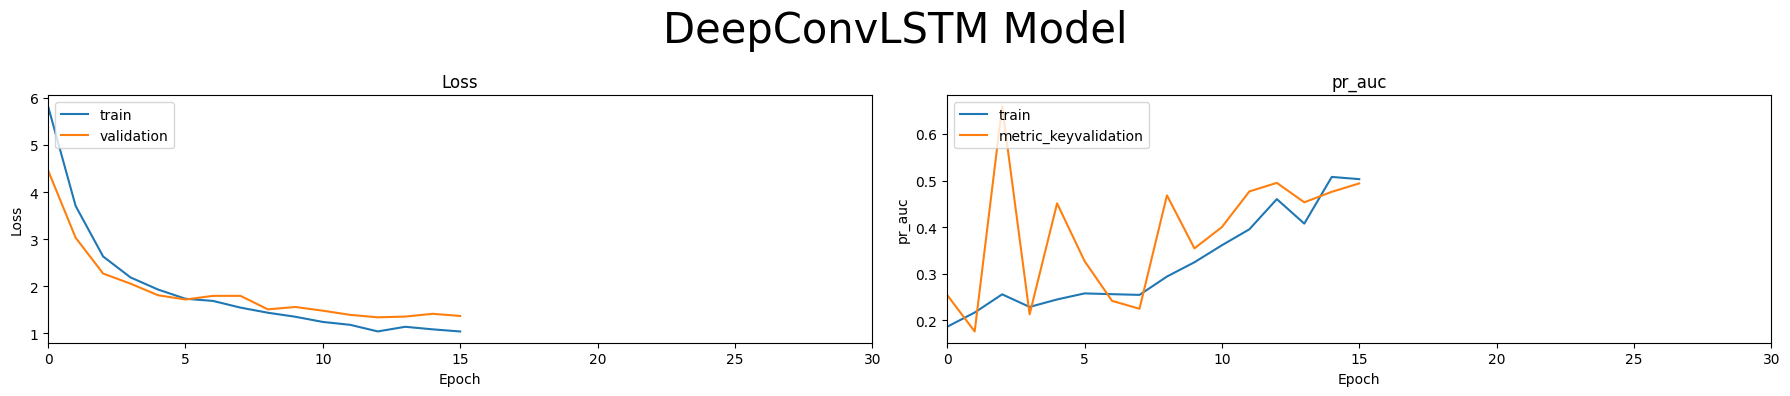

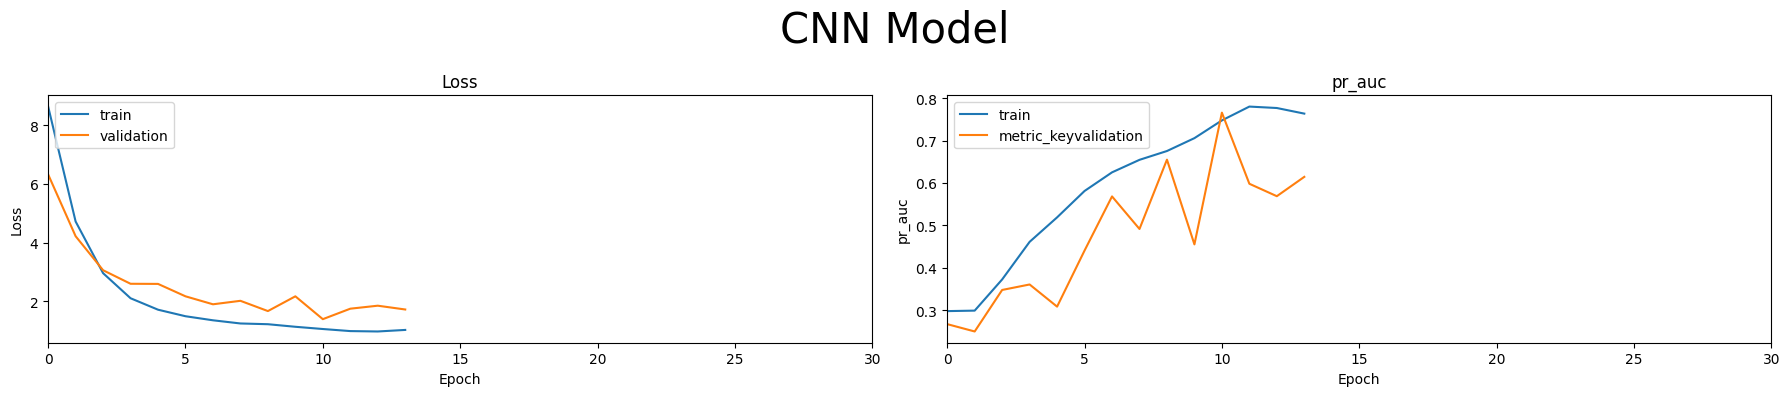

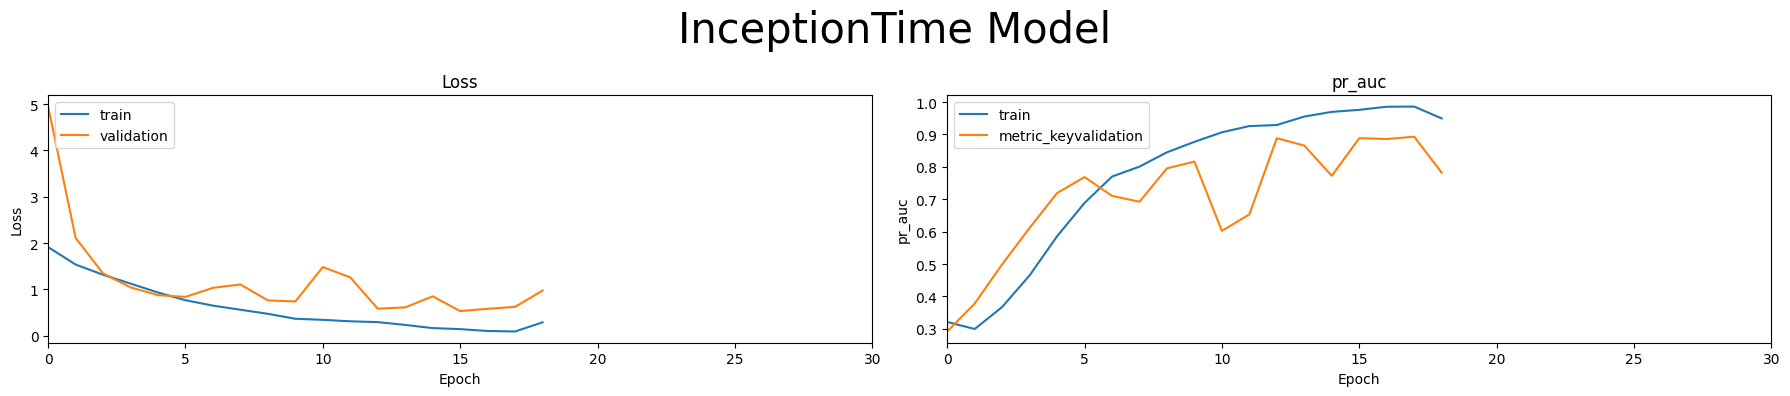

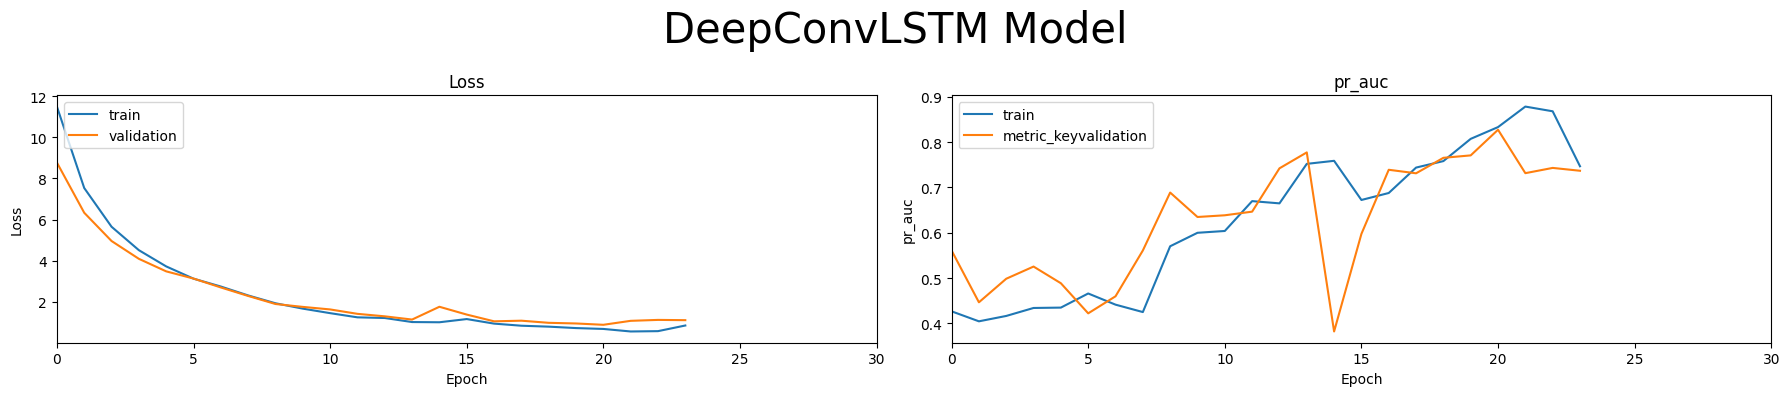

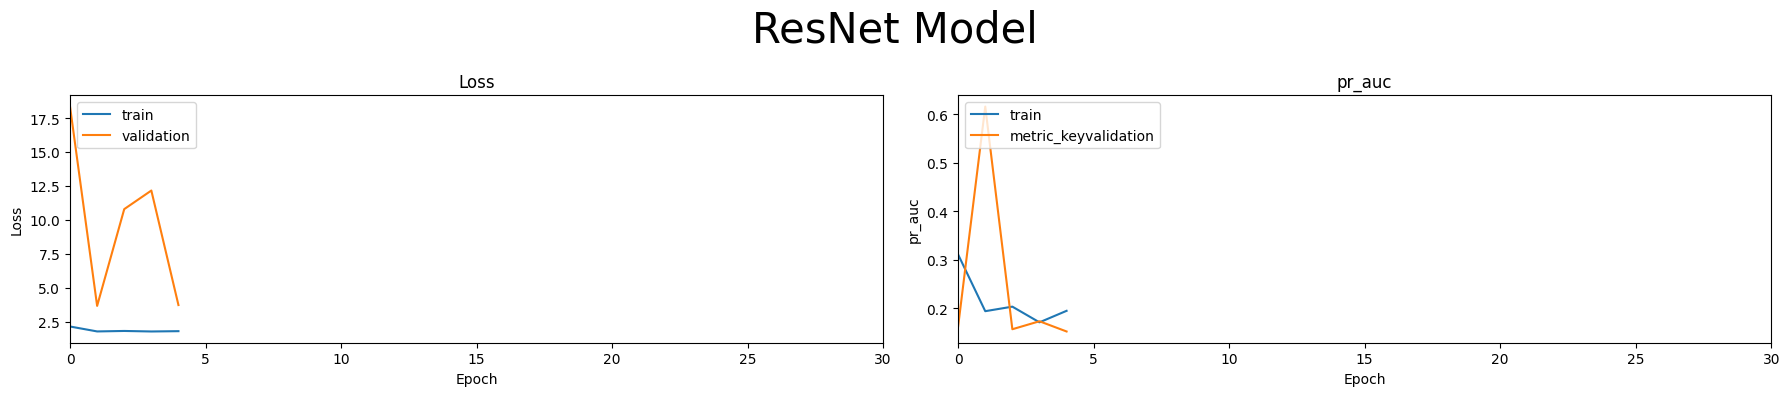

In [67]:
model_types = list(map(lambda m: m[2],models))

for i in range(len(model_types)):
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(18, 4))

    fig.suptitle(f"{model_types[i]} Model", fontsize=30)

    ax1.plot(history[i].history['loss'])
    ax1.plot(history[i].history['val_loss'])
    ax1.set_title('Loss')
    ax1.set_ylabel('Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_xlim([0, 30])
    ax1.legend(['train', 'validation'], loc='upper left')

    ax2.plot(history[i].history[metric_key])
    ax2.plot(history[i].history[f'val_{metric_key}'])
    ax2.set_title(metric_key)
    ax2.set_ylabel(metric_key)
    ax2.set_xlabel('Epoch')
    ax2.set_xlim([0, 30])
    ax2.legend(['train', 'metric_keyvalidation'], loc='upper left')

    plt.tight_layout()
    plt.show()

**Callbacks**

In [68]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10)
checkpoint_path = 'best_model.h5'

checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_path,
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=False,
    verbose=1
)


## **Model Training**

In [69]:
%%time

history = best_model.fit(
    X_train,
    y_train,
    epochs=50,
    callbacks=[early_stopping, checkpoint_callback],
    validation_data=(X_val, y_val),
)

Epoch 1/50
89/89 [==============================] - ETA: 0s - loss: 0.4186 - pr_auc: 0.9256
Epoch 1: val_loss improved from inf to 0.37069, saving model to best_model.h5
89/89 [==============================] - 5s 31ms/step - loss: 0.4186 - pr_auc: 0.9256 - val_loss: 0.3707 - val_pr_auc: 0.9377
Epoch 2/50
89/89 [==============================] - ETA: 0s - loss: 0.3031 - pr_auc: 0.9592
Epoch 2: val_loss improved from 0.37069 to 0.26931, saving model to best_model.h5
89/89 [==============================] - 2s 17ms/step - loss: 0.3031 - pr_auc: 0.9592 - val_loss: 0.2693 - val_pr_auc: 0.9631
Epoch 3/50
89/89 [==============================] - ETA: 0s - loss: 0.2397 - pr_auc: 0.9730
Epoch 3: val_loss improved from 0.26931 to 0.26567, saving model to best_model.h5
89/89 [==============================] - 2s 18ms/step - loss: 0.2397 - pr_auc: 0.9730 - val_loss: 0.2657 - val_pr_auc: 0.9647
Epoch 4/50
88/89 [============================>.] - ETA: 0s - loss: 0.2226 - pr_auc: 0.9763
Epoch 4: val

## **Evaluate**

In [36]:
# load the best checkpoint model
from keras.models import load_model
best_model = load_model('/kaggle/working/best_model.h5')
#model.summary()

In [70]:
import time

t = time.time()
y_pred = best_model.predict(X_test, batch_size=1)
print(time.time() - t)

349/349 [==============================] - 2s 4ms/step
2.0194685459136963


In [71]:
print(f"Classification report fot the Inception model:\n")
print(
    classification_report(
        np.argmax(y_test, axis=1),
        np.argmax(y_pred, axis=1),
        digits=4
    )
)

Classification report fot the Inception model:

              precision    recall  f1-score   support

           0     1.0000    0.9731    0.9864       260
           1     1.0000    1.0000    1.0000        20
           2     0.7241    0.9130    0.8077        23
           3     0.8333    0.8696    0.8511        23
           4     0.9565    0.9565    0.9565        23

    accuracy                         0.9628       349
   macro avg     0.9028    0.9424    0.9203       349
weighted avg     0.9680    0.9628    0.9645       349



#### **Confusion Matrix**

Classification report fot the Inception model:

              precision    recall  f1-score   support

           0     1.0000    0.9731    0.9864       260
           1     1.0000    1.0000    1.0000        20
           2     0.7241    0.9130    0.8077        23
           3     0.8333    0.8696    0.8511        23
           4     0.9565    0.9565    0.9565        23

    accuracy                         0.9628       349
   macro avg     0.9028    0.9424    0.9203       349
weighted avg     0.9680    0.9628    0.9645       349



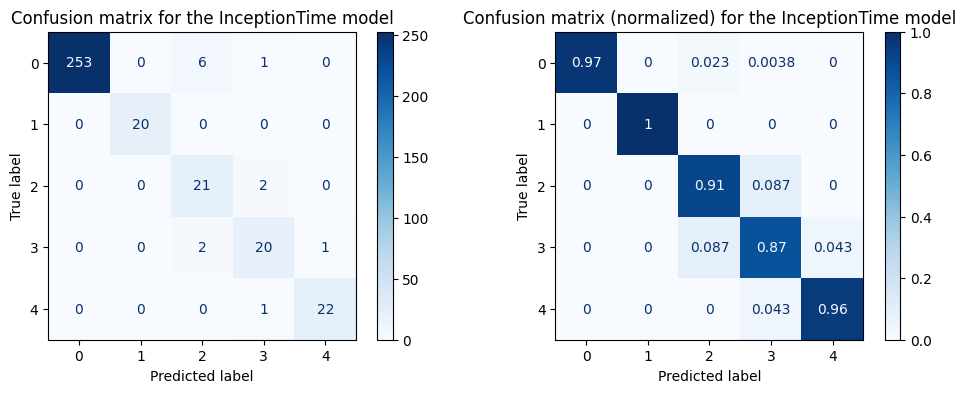

In [72]:
print(f"Classification report fot the Inception model:\n")
print(
    classification_report(
        np.argmax(y_test, axis=1),
        np.argmax(y_pred, axis=1),
        digits=4
    )
)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

ConfusionMatrixDisplay.from_predictions(
    np.argmax(y_test, axis=1),
    np.argmax(y_pred, axis=1),
    display_labels=list(ohe.categories_[0]),
    normalize=None,
    cmap="Blues",
    ax=ax1
)

ax1.set_title(f"Confusion matrix for the {best_model_type} model")

ConfusionMatrixDisplay.from_predictions(
    np.argmax(y_test, axis=1),
    np.argmax(y_pred, axis=1),
    display_labels=list(ohe.categories_[0]),
    normalize="true",
    cmap="Blues",
    ax=ax2
)

ax2.set_title(f"Confusion matrix (normalized) for the {best_model_type} model")
plt.show()

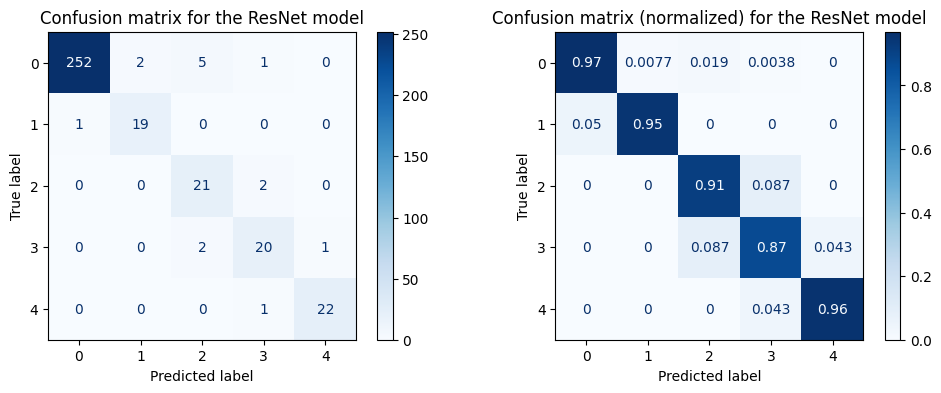

In [58]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

ConfusionMatrixDisplay.from_predictions(
    np.argmax(y_test, axis=1),
    np.argmax(y_pred, axis=1),
    display_labels=list(ohe.categories_[0]),
    normalize=None,
    cmap="Blues",
    ax=ax1
)

ax1.set_title(f"Confusion matrix for the {best_model_type} model")

ConfusionMatrixDisplay.from_predictions(
    np.argmax(y_test, axis=1),
    np.argmax(y_pred, axis=1),
    display_labels=list(ohe.categories_[0]),
    normalize="true",
    cmap="Blues",
    ax=ax2
)

ax2.set_title(f"Confusion matrix (normalized) for the {best_model_type} model")
plt.show()

## **Inception Network for TImeseries**

In [71]:
# import dependencies
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset, random_split
import numpy as np
import seaborn as sns
from sklearn.utils.class_weight import compute_class_weight


**Dataset**

In [72]:
# setup
batch_size = 32
seq_length = 40
num_features = 17
num_classes = 5

# train
X_train_tensor = torch.tensor(X_train).to(torch.float32)
y_train_tensor = torch.tensor(y_train).to(torch.int64)

# valid
X_val_tensor = torch.tensor(X_val).to(torch.float32)
y_val_tensor = torch.tensor(y_val).to(torch.int64)

# test
X_test_tensor = torch.tensor(X_test).to(torch.float32)
y_test_tensor = torch.tensor(y_test).to(torch.int64)


print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)
print(X_test.shape, y_test.shape)


# dataloader

#train
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
#train_dataset, val_dataset, test = random_split(TensorDataset(X_tensor, y_tensor), [train_size, val_size])

#valid
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

#test
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

# train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
# val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# for data in train_loader:
#     print(data[0].shape, data[1].shape, data[1].shape, data[1].dtype)


(2819, 17, 40) (2819,)
(314, 17, 40) (314,)
(349, 17, 40) (349,)


#### **Torch implementation of Model**

In [95]:
class InceptionModule1D(nn.Module):
    def __init__(self, in_channels):
        super(InceptionModule1D, self).__init__()
        
        # introduce conv1d inception block to reduce dimensionality for the first time
        self.cnn = nn.Conv1d(in_channels, 32, kernel_size = 1)
        
        self.branch1x1 = nn.Conv1d(32, 76, kernel_size=1)
        self.branch1x1 = nn.Conv1d(32, 76, kernel_size=1)

        self.branch3x3 = nn.Sequential(
            nn.Conv1d(32, 76, kernel_size=15, padding=7),
            nn.Conv1d(76, 76, kernel_size=15, padding=7)
        )

        self.branch5x5 = nn.Sequential(
            nn.Conv1d(32, 76, kernel_size=31, padding=15),
            nn.Conv1d(76, 76, kernel_size=31, padding=15)
        )
        
        # output channel from inception layer is 64
        self.branch_pool = nn.Sequential(
            nn.Conv1d(in_channels, 76, kernel_size=1),
        )

    def forward(self, x):
        cnn = self.cnn(x)
        
        branch1x1 = self.branch1x1(cnn)

        branch3x3 = self.branch3x3(cnn)

        branch5x5 = self.branch5x5(cnn)
        
        branch_pool = F.avg_pool1d(x, kernel_size=3, stride=1, padding=1)
        branch_pool = self.branch_pool(branch_pool)

        outputs = torch.cat([branch1x1, branch3x3, branch5x5, branch_pool], dim=1)
        return outputs

class InceptionTimeSeriesClassifier(nn.Module):
    def __init__(self, in_channels, num_classes):
        super(InceptionTimeSeriesClassifier, self).__init__()
        self.inception_out = 304
        # bat_norm for input channels
        self.bn1 = nn.BatchNorm1d(in_channels)
        self.inception1 = InceptionModule1D(in_channels)
        
        self.bn2 = nn.BatchNorm1d(self.inception_out)
        # add activation
        self.relu2 = nn.ReLU()
        self.inception2 = InceptionModule1D(self.inception_out)  # 64*4
        
        self.bn3 = nn.BatchNorm1d(self.inception_out)
        # add activation
        self.relu3 = nn.ReLU()
        self.inception3 = InceptionModule1D(self.inception_out)
        
        self.bn4 = nn.BatchNorm1d(self.inception_out)
        # add activation
        self.relu4 = nn.ReLU()
        self.inception4 = InceptionModule1D(self.inception_out)  # 64*4
        
        self.bn4 = nn.BatchNorm1d(self.inception_out)
        # add activation
        self.relu4 = nn.ReLU()
        self.inception5 = InceptionModule1D(self.inception_out)
        
        self.bn5 = nn.BatchNorm1d(self.inception_out)
        # add activation
        self.relu5 = nn.ReLU()
        
        self.global_pool = nn.AdaptiveAvgPool1d(1)
        self.fc = nn.Linear(self.inception_out, num_classes)

    def forward(self, x):
        x = self.bn1(x)
        x = self.inception1(x)
        x = self.bn2(x)
        x = self.relu2(x)
        x = self.inception2(x)
        x = self.bn3(x)
        x = self.relu3(x)
        x = self.inception3(x)
        x = self.bn4(x)
        x = self.relu4(x)
        x = self.inception4(x)
        x = self.bn5(x)
        x = self.relu5(x)
        #x = self.inception4(x)
        
        x = self.global_pool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x


# Training loop with validation
#def train_model(model, train_loader, val_loader, class_weights, num_epochs=10, learning_rate=0.001, save_path='best_model.pth'):
def train_model(model, train_loader, val_loader, num_epochs=10, learning_rate=0.001, save_path='best_model.pth', patience=20):
    #criterion = nn.CrossEntropyLoss(weight=class_weights)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    
    # variable for earlystopping 
    patience_counter = 0
    # LE scheduler
    #scheduler = torch.optim.ReduceLROnPlateau(optimizer, 'min')
    
    best_val_loss = float('inf')
    
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            outputs = model(X_batch)
            #print(y_batch.shape, y_batch.dtype)
            #print(outputs.shape, outputs.dtype)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * X_batch.size(0)

        epoch_loss = running_loss / len(train_loader.dataset)

        # Validation step
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for X_val, y_val in val_loader:
                X_val, y_val = X_val.to(device), y_val.to(device)
                outputs = model(X_val)
                loss = criterion(outputs, y_val)
                val_loss += loss.item() * X_val.size(0)
        val_loss /= len(val_loader.dataset)
        
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Validation Loss: {val_loss:.4f}')
        
        # Note that step should be called after validate()
        #scheduler.step(val_loss)
        
        # Save the best model
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), save_path)
            print(f'Saved best model with validation loss: {val_loss:.4f}')
#         else:
#             patience_counter += 1
#             if patience_counter >= patience:
#                 print("Early stopping")
#                 break


batch_size = 32
seq_length = 40
num_features = 17
num_classes = 5

# define the inception model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Compute class weights based on actual class distribution y
#class_weights = compute_class_weight('balanced', classes=np.unique(y), y=y)
#class_weights = torch.tensor(class_weights, dtype=torch.float32).to(device)


model = InceptionTimeSeriesClassifier(in_channels=num_features, num_classes=num_classes).to(device)
model
            

InceptionTimeSeriesClassifier(
  (bn1): BatchNorm1d(17, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (inception1): InceptionModule1D(
    (cnn): Conv1d(17, 32, kernel_size=(1,), stride=(1,))
    (branch1x1): Conv1d(32, 76, kernel_size=(1,), stride=(1,))
    (branch3x3): Sequential(
      (0): Conv1d(32, 76, kernel_size=(15,), stride=(1,), padding=(7,))
      (1): Conv1d(76, 76, kernel_size=(15,), stride=(1,), padding=(7,))
    )
    (branch5x5): Sequential(
      (0): Conv1d(32, 76, kernel_size=(31,), stride=(1,), padding=(15,))
      (1): Conv1d(76, 76, kernel_size=(31,), stride=(1,), padding=(15,))
    )
    (branch_pool): Sequential(
      (0): Conv1d(17, 76, kernel_size=(1,), stride=(1,))
    )
  )
  (bn2): BatchNorm1d(304, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): ReLU()
  (inception2): InceptionModule1D(
    (cnn): Conv1d(304, 32, kernel_size=(1,), stride=(1,))
    (branch1x1): Conv1d(32, 76, kernel_size=(1,), stride=(1,))
   

#### **Model Training**

In [96]:
#     X, y = generate_data(1000, seq_length, num_features, num_classes)

#     # Splitting data into train and validation sets
#     train_size = int(0.8 * len(X))
#     val_size = len(X) - train_size
#     train_dataset, val_dataset = random_split(TensorDataset(X, y), [train_size, val_size])

#     train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
#     val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Train the model with validation
#train_model(model, train_loader, val_loader, class_weights, num_epochs=100)
train_model(model, train_loader, val_loader, num_epochs=150)


Epoch [1/150], Loss: 0.9380, Validation Loss: 0.9854
Saved best model with validation loss: 0.9854
Epoch [2/150], Loss: 0.8027, Validation Loss: 0.7061
Saved best model with validation loss: 0.7061
Epoch [3/150], Loss: 0.6797, Validation Loss: 0.6098
Saved best model with validation loss: 0.6098
Epoch [4/150], Loss: 0.5925, Validation Loss: 0.4961
Saved best model with validation loss: 0.4961
Epoch [5/150], Loss: 0.5181, Validation Loss: 0.4484
Saved best model with validation loss: 0.4484
Epoch [6/150], Loss: 0.4795, Validation Loss: 0.3471
Saved best model with validation loss: 0.3471
Epoch [7/150], Loss: 0.4242, Validation Loss: 0.3626
Epoch [8/150], Loss: 0.3584, Validation Loss: 0.3294
Saved best model with validation loss: 0.3294
Epoch [9/150], Loss: 0.3702, Validation Loss: 0.2908
Saved best model with validation loss: 0.2908
Epoch [10/150], Loss: 0.3581, Validation Loss: 0.2092
Saved best model with validation loss: 0.2092
Epoch [11/150], Loss: 0.2842, Validation Loss: 0.2431
E

#### **Evaluation**

In [77]:
# Evaluate model and plot confusion matrix
def evaluate_model(model, test_loader):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for X_test, y_test in test_loader:
            X_test, y_test = X_test.to(device), y_test.to(device)
            outputs = model(X_test)
            _, preds = torch.max(outputs, 1)
            all_preds.append(preds.cpu().numpy())
            all_labels.append(y_test.cpu().numpy())
    all_preds = np.concatenate(all_preds)
    all_labels = np.concatenate(all_labels)

    cm = confusion_matrix(all_labels, all_preds)
    print(classification_report(all_labels, all_preds))

    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=range(num_classes), yticklabels=range(num_classes))
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

**Confusion Matrix**

In [98]:
# laod best model
model.load_state_dict(torch.load("/kaggle/working/best_model.pth"))

<All keys matched successfully>

              precision    recall  f1-score   support

           0       1.00      0.98      0.99       260
           1       1.00      0.95      0.97        20
           2       0.76      0.83      0.79        23
           3       0.85      0.96      0.90        23
           4       0.96      0.96      0.96        23

    accuracy                           0.97       349
   macro avg       0.91      0.93      0.92       349
weighted avg       0.97      0.97      0.97       349



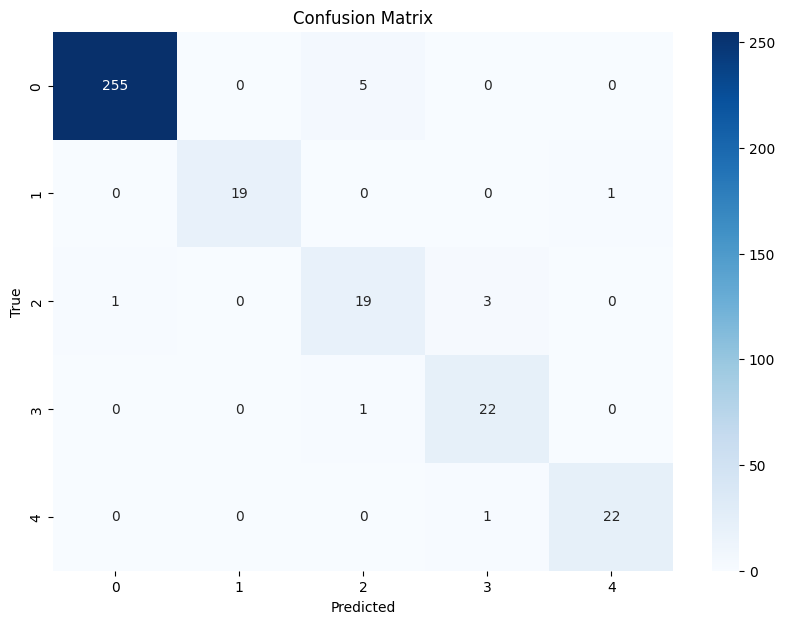

In [34]:
evaluate_model(model, test_loader)

**Using Simple Inception**

              precision    recall  f1-score   support

           0       1.00      0.97      0.99       260
           1       1.00      0.95      0.97        20
           2       0.81      0.91      0.86        23
           3       0.78      0.91      0.84        23
           4       0.88      0.91      0.89        23

    accuracy                           0.96       349
   macro avg       0.89      0.93      0.91       349
weighted avg       0.96      0.96      0.96       349



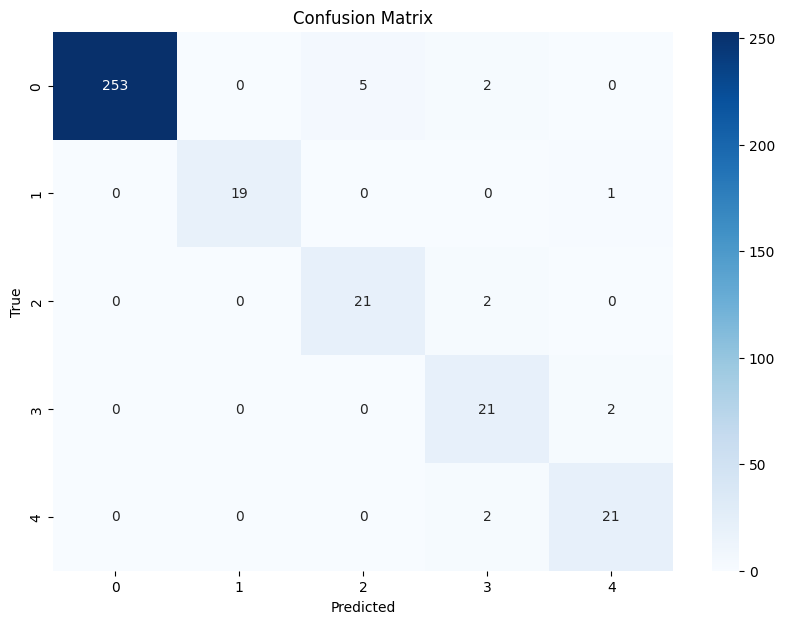

In [78]:
evaluate_model(model, test_loader)

#### **Best result till now Inception + Attention**

              precision    recall  f1-score   support

           0       1.00      0.98      0.99       260
           1       0.95      1.00      0.98        20
           2       0.91      0.87      0.89        23
           3       0.85      1.00      0.92        23
           4       0.91      0.91      0.91        23

    accuracy                           0.97       349
   macro avg       0.93      0.95      0.94       349
weighted avg       0.98      0.97      0.97       349



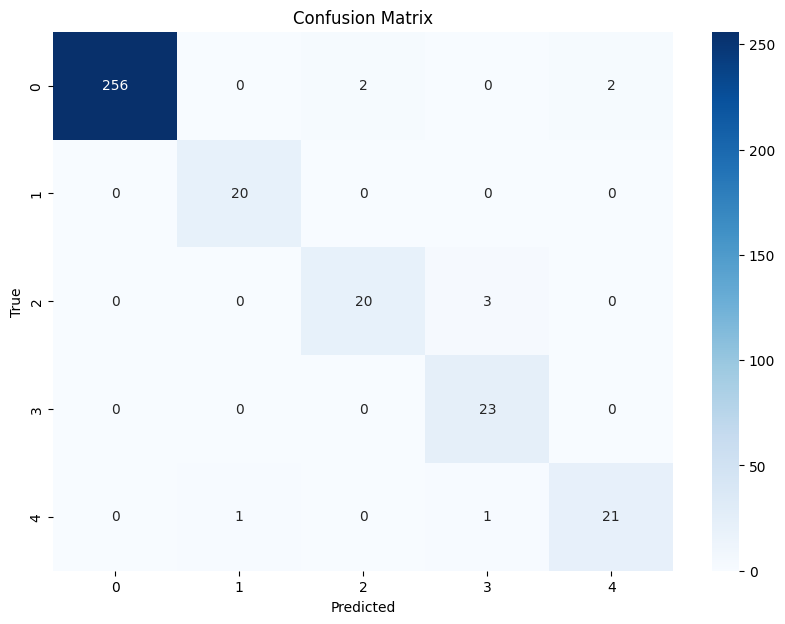

In [83]:
evaluate_model(model, test_loader) 

## **Zipping to download from Kaggle**

In [74]:
import zipfile
import os
from IPython.display import FileLink

def zip_dir(directory = os.curdir, file_name = 'directory.zip'):
    """
    zip all the files in a directory
    
    Parameters
    ___
    directory: str
        directory needs to be zipped, defualt is current working directory
        
    file_name: str
        the name of the zipped file (including .zip), default is 'directory.zip'
        
    Returns
    ___
    Creates a hyperlink, which can be used to download the zip file)
    """
    os.chdir(directory)
    zip_ref = zipfile.ZipFile(file_name, mode='w')
    for folder, _, files in os.walk(directory):
        for file in files:
            if file_name in file:
                pass
            else:
                zip_ref.write(os.path.join(folder, file))

    return FileLink(file_name)

In [75]:
zip_dir(file_name = 'ALFA_experiment_jul_21_acc_96_28.zip')

/kaggle/working/ALFA_experiment_jul_21_acc_96_28.zip